In [90]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os 
import networkx as nx
import igraph as ig
from ts2vg import NaturalVG

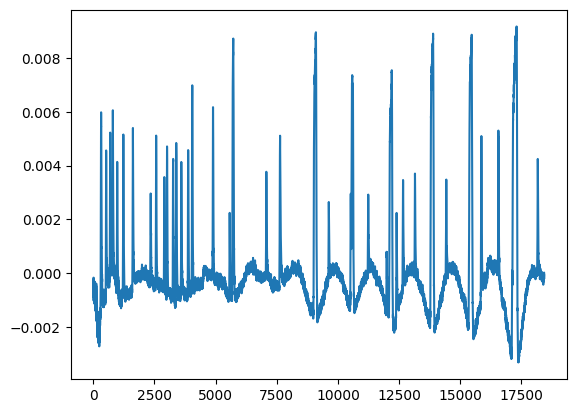

In [100]:
# data input

timeseries = []
datadir = "Data\PreviousData_v2\\"
for each in os.listdir("Data\PreviousData_v2"):
    timeseries.append(list(scipy.io.loadmat(datadir+each)["X"][0]))
 
rawTimeseries = []
for signal in timeseries:
    i = 0
    individualSignalSliced = []
    while (i + 1000) < len(signal):
        individualSignalSliced.append(signal[i:i+1000])
        i += 1000
    rawTimeseries.append(individualSignalSliced)

plt.plot(timeseries[0])

In [92]:
ts = rawTimeseries[0][0]

# builds natural visibility graph
vg = NaturalVG()
vg.build(ts)

import matplotlib.pyplot as plt
ig.plot(vg.as_igraph())


In [93]:
# convert time series into natural visibility graphes
# https://github.com/CarlosBergillos/ts2vg

def construct_visibilty_graph(ts):
    # builds natural visibility graph
    vg = NaturalVG()
    vg.build(ts)
    # converts to networkx graph format
    g = vg.as_networkx()
    return g

def get_degree_sequence(vg):
    # get [(node, degrees),...] from a vg
    # convert to dict
    # get values (the degrees)
    ds = list(dict(nx.degree(vg)).values())
    return ds

# Calculate the distance matrix for a single time series segment
# def get_distance_matrix(individualSignalSliced):
#     n = len(individualSignalSliced)
#     distance_matrix = np.zeros((n, n))
#     for i in range(n):
#         for j in range(i, n):
#             print(individualSignalSliced[i])
#             ki = get_degree_centrality(individualSignalSliced[i])
#             kj = get_degree_centrality(individualSignalSliced[j])
#             d = np.linalg.norm(np.array(ki) - np.array(kj))
#             distance_matrix[i, j] = d
#             distance_matrix[j, i] = d
#     return distance_matrix

Finding visibility graphes
Finding degree sequences or 'feature vectors'
Finding distance matrices
[[0.         0.34687635 0.33697287 ... 0.76328525 0.75493067 0.76718621]
 [0.34687635 0.         0.28300877 ... 0.6320213  0.62826967 0.63879916]
 [0.33697287 0.28300877 0.         ... 0.71706177 0.70934463 0.71981896]
 ...
 [0.76328525 0.6320213  0.71706177 ... 0.         0.83660455 0.8673934 ]
 [0.75493067 0.62826967 0.70934463 ... 0.83660455 0.         0.87313378]
 [0.76718621 0.63879916 0.71981896 ... 0.8673934  0.87313378 0.        ]]
[[0.         0.80522205 0.80522205 ... 1.0395372  1.0395372  1.0395372 ]
 [0.80522205 0.         0.56937797 ... 0.66734824 0.66734824 0.66734824]
 [0.80522205 0.56937797 0.         ... 0.86973922 0.86973922 0.86973922]
 ...
 [1.0395372  0.66734824 0.86973922 ... 0.         0.92979033 0.92979033]
 [1.0395372  0.66734824 0.86973922 ... 0.92979033 0.         0.92979033]
 [1.0395372  0.66734824 0.86973922 ... 0.92979033 0.92979033 0.        ]]


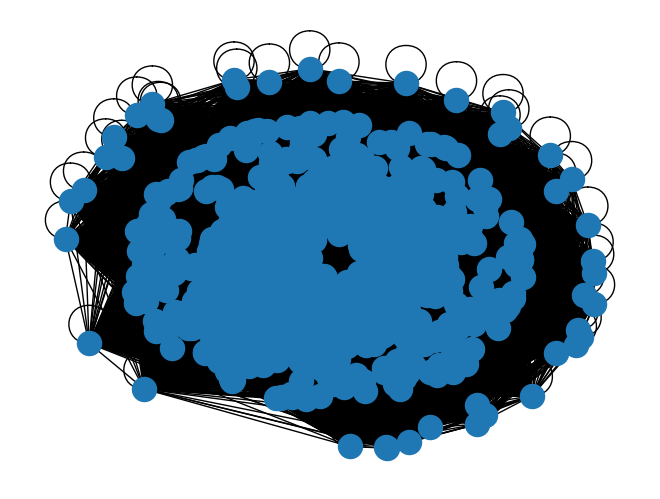

In [99]:
from scipy.spatial.distance import euclidean
from networkx import to_numpy_array

print("Finding visibility graphes")
# construct a vg for all slices in all timeseries
vgTimeseries = rawTimeseries[:]
for i in range(len(rawTimeseries)):
    vgTimeseries[i] = [construct_visibilty_graph(slice) for slice in rawTimeseries[i]]


print("Finding degree sequences or 'feature vectors'")
# construct a degree seq for all slices in all timeseries
degreeeSequences = vgTimeseries[:]
for i in range(len(vgTimeseries)):
    degreeeSequences[i] = [get_degree_sequence(vg) for vg in vgTimeseries[i]]

print("Finding distance matrices")
Gs = vgTimeseries[0]
dss = degreeeSequences[0]
timesteps = len(rawTimeseries)

from sklearn.metrics.pairwise import euclidean_distances

# compute distance matrices for each segment
DMs = []
for i in range(timesteps):
    A = nx.to_numpy_array(Gs[i])  # adjacency matrix of visibility graph
    K = A / A.sum(axis=1)[:, None]  # row-normalized adjacency matrix
    D = euclidean_distances(K)  # compute pairwise Euclidean distances between rows of K
    DMs.append(D)

# compute global distance matrix (simple average of matrices in DMs)
gDM = np.zeros_like(DMs[0])
for DM in DMs:
    gDM += DM
gDM /= len(DMs)

# compute normalized distance matrix
dmMin = np.min(gDM)
dmMax = np.max(gDM)
dmNorm = (D - dmMin) / (dmMax - dmMin)

# Compute similarity matrix
simMatrix = 1 - dmNorm

print(gDM)
print(dmNorm)

# Build weighted graph from similarity matrix
weightedGraph = nx.from_numpy_array(simMatrix)

# Set edge weights to similarity values
for u, v, d in weightedGraph.edges(data=True):
    d['weight'] = simMatrix[u][v]

print()
nx.draw(weightedGraph)


{0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 2, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 2, 97: 0, 98: 0, 99: 0, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 3, 119: 0, 120: 0, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 2, 127: 2, 128: 2, 129: 2, 130: 2, 131: 2, 132: 2, 133: 2, 134: 2, 135: 2, 136: 2, 137: 2, 138: 

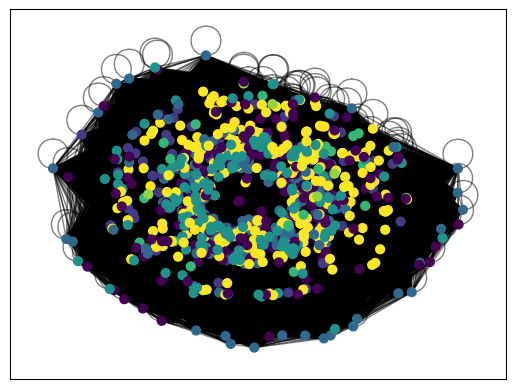

In [101]:
# community detection (clustering) of weighted graphes
# https://github.com/taynaud/python-louvain

# To achieve a modular visualization of the clusters detected by the discussed method and their
# mutual connections, we used a force-directed algorithm, namely the Frushterman–Reingold layout,
# as a graphical representation.
# Finally, for specific unsupervised FSS purposes, we considered a representative parameter for
# each cluster. Such parameters were identified based on their importance within the communities,
# by considering the signals with highest total degree centrality in their respective groups.

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(weightedGraph)

print(partition)

# draw the graph
pos = nx.spring_layout(weightedGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(weightedGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(weightedGraph, pos, alpha=0.5)
plt.show()


In [96]:
# pruning of graphes
# perform edge pruning by filtering the pairwise similarities lower than the second quantile of their probability distribution